<font color="#5254A3" size=20><b>Telecom X - Machine Learning</b></font>

<font size=4>Criando modelos preditivos para detecção de evasão de clientes na empresa de telecomunicações Telecom X</font>.

In [97]:
!pip install lifelines

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

#📌 Extração

In [99]:
url = 'https://raw.githubusercontent.com/RavyBomfim/Telecom-X-ETL/refs/heads/main/TelecomX_Data_Clean.csv'
data = pd.read_csv(url)
data.head()

,CustomerID,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Charges.Daily
0,0002-ORFBO,No,Female,No,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.20
1,0003-MKNFE,No,Male,No,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.01
2,0004-TLHLJ,Yes,Male,No,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.34
3,0011-IGKFF,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.17
4,0013-EXCHZ,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.97


In [100]:
data.shape

(7032, 22)

### Informações obtidas na análise anterior

A análise exploratória feita durante o processo de ETL, disponível em [Telecom X - ETL](https://github.com/RavyBomfim/Telecom-X-ETL/blob/main/TelecomX_ETL.ipynb), forneceu informações relevantes. A partir dela, sabemos que:

* A taxa de evasão é de 26,6%, enquanto os que permaceram correspondem a 73,4%;
Contratos mensais concentram a maior parte das evasões.

* A ausência de serviços complementares (segurança online, backup, proteção de dispositivos, suporte técnico) parece estar fortemente associada a maiores índices de cancelamento.

* Cheque eletrônico é o método de pagamento mais associado à evasão.

* A taxa de evasão é maior entre clientes que pagam por fatura online.

* Planos de fibra óptica, possuem custo mais alto e apresentam maior cancelamento.

* Idosos, não casados e sem dependentes têm maior propensão à saída.

* Contratos mensais concentram a maior parte das evasões, enquanto os anuais e de dois anos costumam ter poucos cancelamentos.

* Clientes que cancelam costumam ter cobrança mensal mais alta.

* O sexo do cliente, assim como possuir ou não serviço telefônico, parecem não ter relação direta com as evasões.

> Também foram gerados diversos gráficos a partir do cruzamento de várias variáveis, portanto, a seguir serão criados apenas gráficos que não constam na análise anterior.

#🛠️ Preparação dos Dados

#### Remoção de colunas irrelevantes

A princípio, apenas a coluna "customerID" será excluída. Outras colunas também podem ser excluídas posteriormente, se necessário.

In [101]:
data_copy = data.drop(columns='CustomerID')
data_copy.columns

Index(['Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Charges.Monthly', 'Charges.Total', 'Charges.Daily'],
      dtype='object')

#### Inconsistências

Não haverá tratamento de valores nulos, duplicados, em branco ou outras inconsistências, pois os dados já foram tratados no processo anterior (ETL).

#### Cores dos gráficos e configuração de estilo do Seaborn

In [102]:
gray_1 = '#444'; gray_2 = '#585858'; gray_3 = '#797979'; gray_4 = '#858585';
gray_5 = '#EBEBEB'; purple_1 = '#393B79'; purple_2 = '#5254A3'; pink_1 = '#C4285A';
pink_2 = '#DE4968'; green_1 = '#417568'; reen_2 = '#559184'

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 5)

#### Transformando a coluna "Churn" em numérica

In [103]:
data_copy['Churn'] = data_copy['Churn'].map({'Yes': 1, 'No': 0})
data_copy.head()

,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Charges.Daily
0,0,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.20
1,0,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.01
2,1,Male,No,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.34
3,1,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.17
4,1,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.97


#### Curva de Sobrevivência Kaplan-Meier

Para verificar a probabilidade de permanência do cliente por tipo de contrato.

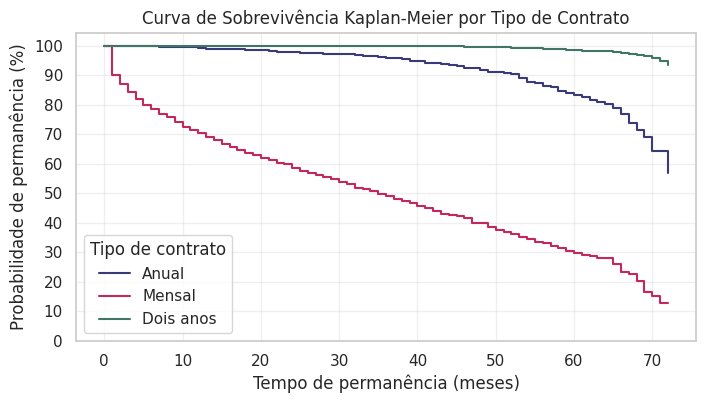

In [104]:
def graph_survival_curve():
  kmf = KaplanMeierFitter()
  values_contract = {'One year': 'Anual', 'Month-to-month': 'Mensal', 'Two year': 'Dois anos'}

  colors = [purple_1, pink_1, green_1]
  fig, ax = plt.subplots(figsize=(8, 4))

  for i, contract in enumerate(data['Contract'].unique()):
      mask = data_copy['Contract'] == contract
      kmf.fit(durations=data_copy[mask]['Tenure'], event_observed=data_copy[mask]['Churn'],
              label=values_contract.get(contract))
      kmf.plot_survival_function(ci_show=False, color=colors[i % len(colors)])

  ax.set_yticks(np.arange(0, 1.1, 0.1))
  yticks = ax.get_yticks()
  ax.set_yticklabels([f'{int(y*100)}' for y in yticks])

  plt.title('Curva de Sobrevivência Kaplan-Meier por Tipo de Contrato')
  plt.xlabel('Tempo de permanência (meses)')
  plt.ylabel('Probabilidade de permanência (%)')
  plt.legend(title='Tipo de contrato')

  plt.grid(True, alpha=0.3)
  plt.show()


graph_survival_curve()

#### Correlação entre as variáveis numéricas e a coluna de evasão (Churn)

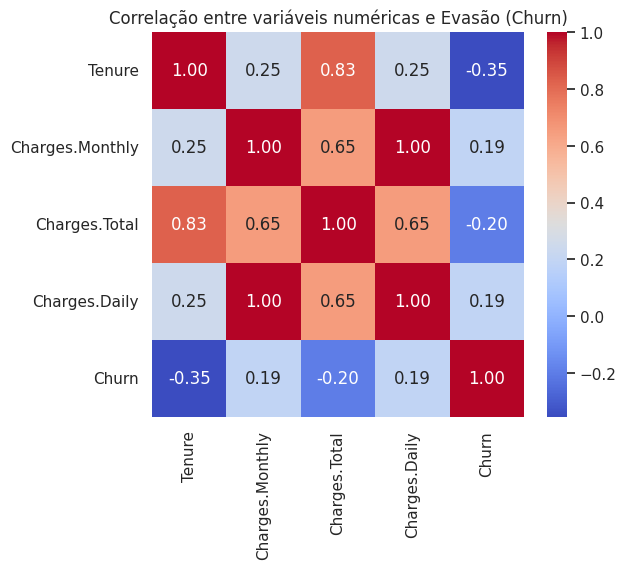

In [105]:
numeric_cols = ['Tenure', 'Charges.Monthly', 'Charges.Total', 'Charges.Daily']
corr = data_copy[numeric_cols + ['Churn']].copy()

plt.figure(figsize=(6, 5))
sns.heatmap(corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre variáveis numéricas e Evasão (Churn)')
plt.show()


#### Removendo colunas com alta correlação

* O gráfico de correlação acima apontou 100% de correlação entre as colunas "Charges.Monthly" e "Charges.Daily", o que já era esperado, devido ao fato da coluna "Charges.Daily" ser derivada da cobrança mensal.

* As colunas "Charges.Total" e "Tenure" também tem uma alta correlação, pois a coluna "Charges.Total" é basicamente a cobrança mensal "Charges.Monthly" multiplicada pelo tempo de permanência "Tenure".

> Devido a isso, as colunas "Charges.Daily" e "Charges.Total" serão excluídas para não prejudicar a análise.

In [106]:
data_clean = data_copy.drop(columns=['Charges.Total', 'Charges.Daily'])
data_clean.columns

Index(['Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Charges.Monthly'],
      dtype='object')

#### Selecionando as variáveis categóricas

In [107]:
categorical_columns = [col for col in data_clean.columns if not pd.api.types.is_numeric_dtype(data_clean[col])]

#### Transormando os valores 'No internet service' em 'No'

In [108]:
data_clean[categorical_columns] = data_clean[categorical_columns].replace('No internet service', 'No')

for col in data_clean.columns:
  print(f'{col}: {data_clean[col].unique()}')

Churn: [0 1]
Gender: ['Female' 'Male']
SeniorCitizen: ['No' 'Yes']
Partner: ['Yes' 'No']
Dependents: ['Yes' 'No']
Tenure: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
PhoneService: ['Yes' 'No']
MultipleLines: ['No' 'Yes' 'No phone service']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['Yes' 'No']
StreamingTV: ['Yes' 'No']
StreamingMovies: ['No' 'Yes']
Contract: ['One year' 'Month-to-month' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
Charges.Monthly: [65.6  59.9  73.9  ... 91.75 68.8  67.85]


#### Encoding

Transformando as colunas categóricas binárias em 0 e 1 e codificando as demais

In [109]:
categorical_binaries = [col for col in categorical_columns if data_clean[col].nunique() == 2 and col != 'Gender']
for col in categorical_binaries:
  data_clean[col] = data_clean[col].map({'No': 0, 'Yes': 1, False: 0, True: 1})

other_categorical = [col for col in categorical_columns if data_clean[col].nunique() > 2 or col == 'Gender']
data_encoded = pd.get_dummies(data_clean, columns=other_categorical, drop_first=True, dtype=int)

data_encoded.head()

,Churn,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Gender_Male,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,1,9,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,9,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
2,1,0,0,0,4,1,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
3,1,1,1,0,13,1,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0
4,1,1,1,0,3,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


In [110]:
data_encoded.shape

(7032, 24)

In [111]:
data_encoded.columns

Index(['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'Charges.Monthly', 'Gender_Male', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

#### Verificando se há presença de valores infinitos e nulos após o encode

In [112]:
bool(np.isinf(data_encoded.values).any())

False

In [113]:
data_encoded.isna().sum().sum()

np.int64(0)

## Análise de Correlação e Multicolinearidade

#### Correlação de todas as variáveis com a Evasão

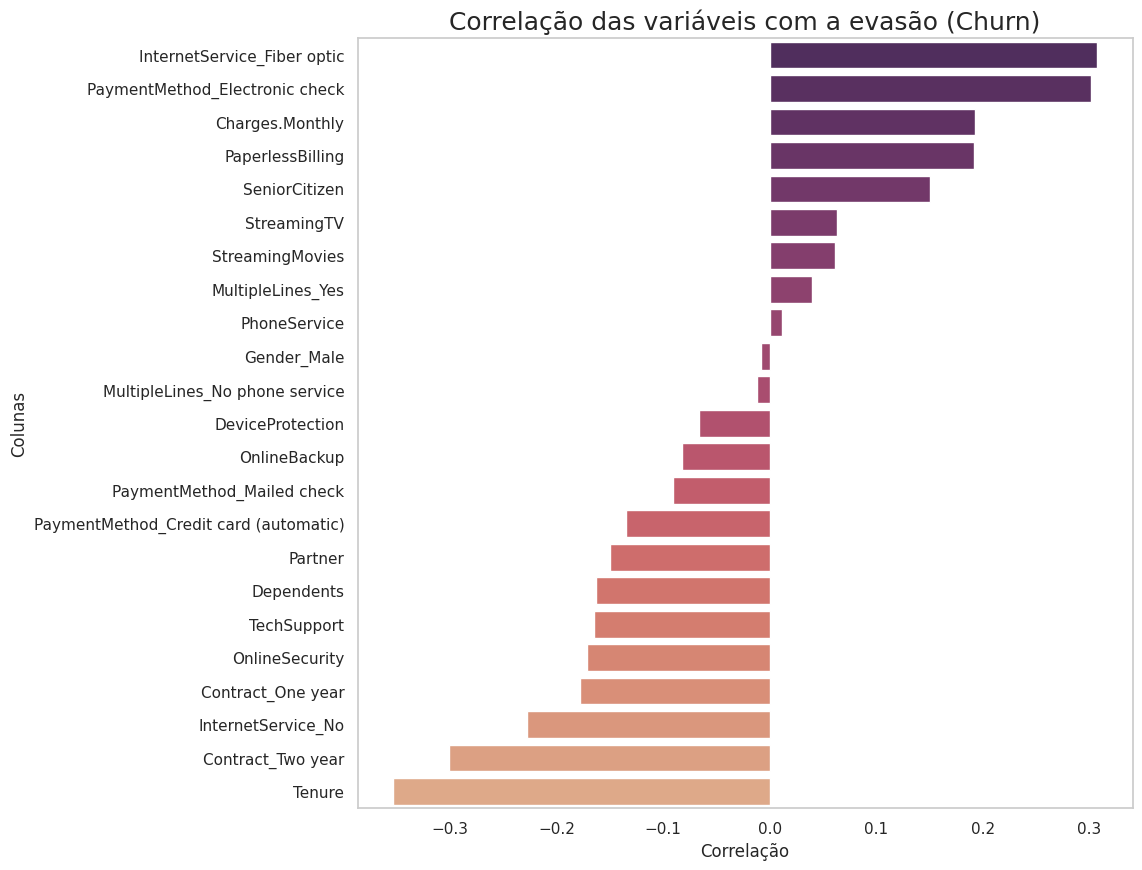

In [114]:
def corr_with_churn(title, df, grid_status=False):
  plt.figure(figsize=(10, 10))
  palette = sns.color_palette('crest')
  corr = df.corr()['Churn'].sort_values(ascending=False)
  sns.barplot(x=corr.values[1:], y=corr.index[1:], hue=corr.index[1:], palette=sns.color_palette('flare', len(corr.index[1:]))[::-1])
  plt.title(title, fontsize=18)
  plt.xlabel('Correlação')
  plt.ylabel('Colunas')
  plt.grid(grid_status)
  plt.show()

corr_with_churn('Correlação das variáveis com a evasão (Churn)', data_encoded)

O gráfico de correlação de todas as variáveis com a evasão (Churn) confirma que tanto o sexo do cliente (Gender) quanto a posse de serviço telefônico (PhoneService) apresentam correlação praticamente nula com a variável alvo. Por esse motivo, essas colunas estão sendo consideradas para remoção.

Além disso, a coluna PhoneService é redundante em relação à coluna MultipleLines, reforçando sua exclusão do conjunto de dados. Já a variável Gender, agora representada por Gender_Male, a princípio será mantida.

#### Verificando se há inconsistências entre PhoneService e MultipleLines antes da exclusão da coluna PhoneService

In [115]:
inconsistencias = data_encoded[
    ((data_encoded['PhoneService'] == 1) & (data_encoded['MultipleLines_No phone service'] == 1)) |
    ((data_encoded['PhoneService'] == 0) & (data_encoded['MultipleLines_Yes'] == 1))
]

print(f"Número de inconsistências: {len(inconsistencias)}")
display(inconsistencias.head())


Número de inconsistências: 0


,Churn,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Gender_Male,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check


#### Excluindo a coluna PhoneService

In [116]:
data_encoded = data_encoded.drop(columns='PhoneService')
data_encoded.head(0)

,Churn,SeniorCitizen,Partner,Dependents,Tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Gender_Male,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check


#### Análise de correlação entre as variáveis para identificar possíveis causas de multicolinearidade

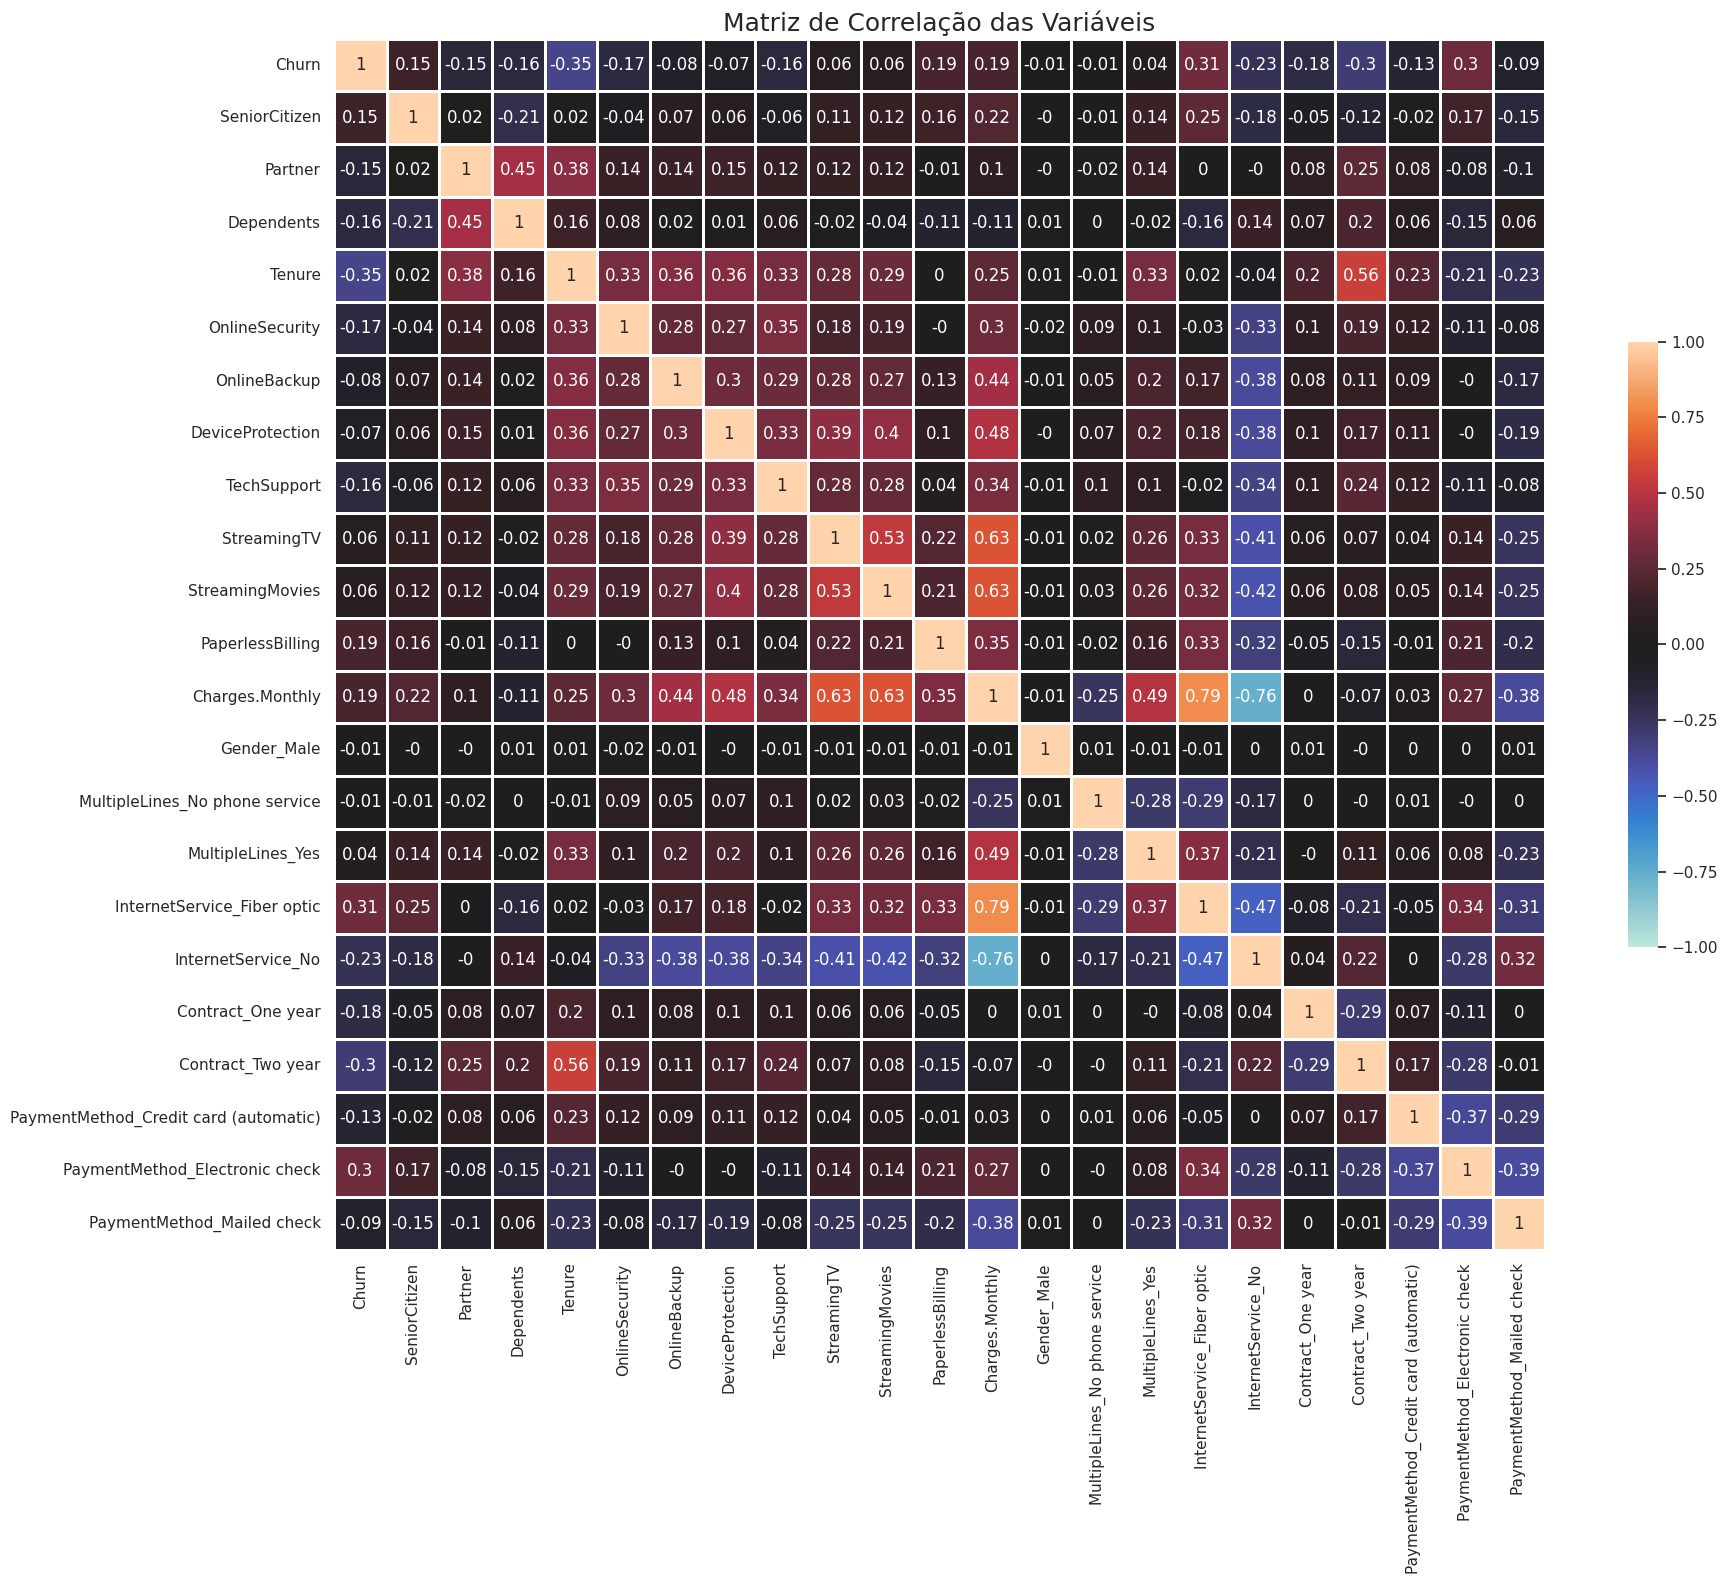

In [117]:
corr = data_encoded.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0, linewidths=2, annot=True, cbar_kws={'shrink': .5}, square=True)

plt.title('Matriz de Correlação das Variáveis', fontsize=18)
plt.tight_layout()
plt.show()

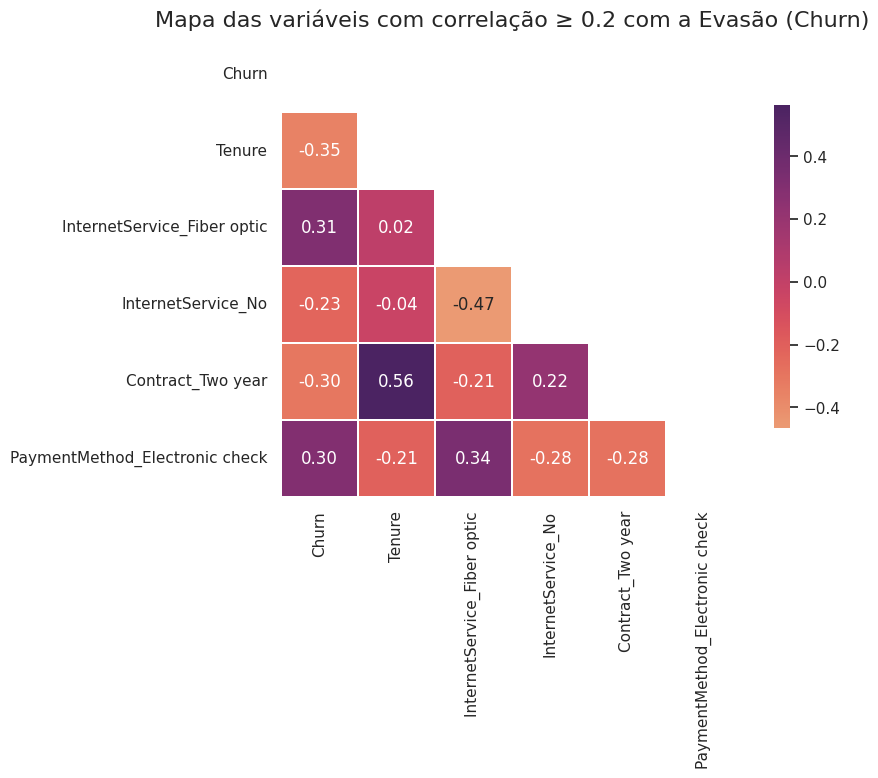

In [118]:
target_var = 'Churn'
threshold = 0.2
corr = data_encoded.corr()
relevant_vars = corr.index[abs(corr[target_var]) >= threshold].tolist()

if target_var not in relevant_vars:
  relevant_vars.append(target_var)

filtered_corr = corr.loc[relevant_vars, relevant_vars]
mask = np.triu(np.ones_like(filtered_corr, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr, annot=True, fmt='.2f', cmap='flare',
            center=0, square=True, linewidths=0.2, cbar_kws={'shrink': 0.7}, mask=mask)

plt.grid(False)
plt.title(f'Mapa das variáveis com correlação ≥ {threshold} com a Evasão ({target_var})', fontsize=16)
plt.show()

#### Fator de Inflação da Variância (VIF)

In [119]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = data_encoded.drop(columns='Churn')
X_constant = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]

display(vif_data.sort_values(by='VIF', ascending=False))

,Feature,VIF
0,const,1950.636106
12,Charges.Monthly,863.723924
16,InternetService_Fiber optic,148.500782
17,InternetService_No,104.133342
14,MultipleLines_No phone service,34.892263
10,StreamingMovies,24.150902
9,StreamingTV,24.075758
15,MultipleLines_Yes,7.286726
7,DeviceProtection,6.906050
6,OnlineBackup,6.761657


#### Excluindo a coluna "InternetService_No"

In [120]:
data_encoded = data_encoded.drop(columns='InternetService_No')

#### Recalculando VIF

In [121]:
X = data_encoded.drop(columns='Churn')
X_constant = add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_constant.columns
vif_data['VIF'] = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]

display(vif_data.sort_values(by='VIF', ascending=False))

,Feature,VIF
0,const,38.446556
12,Charges.Monthly,22.336364
16,InternetService_Fiber optic,7.553029
4,Tenure,2.826562
18,Contract_Two year,2.630079
10,StreamingMovies,2.417444
9,StreamingTV,2.399620
20,PaymentMethod_Electronic check,1.973257
8,TechSupport,1.848965
21,PaymentMethod_Mailed check,1.837626


Apesar de apresentar elevado fator de inflação da variância (VIF), a variável Charges.Monthly será mantida devido à sua relevância para fins preditivos. O valor mensal cobrado ao cliente concentra, de forma direta, os impactos de diversos serviços contratados, tornando-se um indicador altamente informativo sobre o risco de evasão.

## Modelos Preditivos

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

#### Divisão dos dados

Separando as colunas explicativas e a coluna alvo

In [123]:
X = data_encoded.drop(columns='Churn')
y = data_encoded['Churn']

Separando os dados em dados de treino e de teste

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#### Função para calcular e mostrar as métricas

In [125]:
def display_metrics(model_type, y_test, y_predict, y_probably):
  print(f'{model_type} \n')
  print(f'Acurácia: {accuracy_score(y_test, y_predict)}')
  print(f'ROC AUC: {roc_auc_score(y_test, y_probably)}')
  print(f'Matriz de Confusão: \n{confusion_matrix(y_test, y_predict)} \n')
  print('-' * 55)
  title = 'Relatório de Classificação'
  print(f'| {title} {" " * (55 - (len(title) + 5))} | \n{"-" * 55} \n{classification_report(y_test, y_predict)}')
  print('-' * 55)

#### DummyClassifier

O DummyClassifier é um modelo simples que serve como linha de base para avaliação dos modelos preditivos.

##### Treinando o modelo Dummy

In [126]:
model_dummy = DummyClassifier()
model_dummy.fit(X_train, y_train)

DummyClassifier()

##### Prevendo com o modelo Dummy

In [127]:
y_predict_dummy = model_dummy.predict(X_test)
y_probably_dummy = model_dummy.predict_proba(X_test)[:, 1]

display_metrics('Modelo Dummy', y_test, y_predict_dummy, y_probably_dummy)

Modelo Dummy 

Acurácia: 0.7341232227488151
ROC AUC: 0.5
Matriz de Confusão: 
[[1549    0]
 [ 561    0]] 

-------------------------------------------------------
| Relatório de Classificação                          | 
------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1549
           1       0.00      0.00      0.00       561

    accuracy                           0.73      2110
   macro avg       0.37      0.50      0.42      2110
weighted avg       0.54      0.73      0.62      2110

-------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Proporção da Evasão (Churn)

Já sabemos a proporção da evasão, devido à análise exploratória no processo de ETL, mas iremos conferir novamente.

In [128]:
data_encoded['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.734215
1,0.265785


#### Normalização

In [129]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

#### Balanceamento de Classes

In [130]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_normalized, y_train)

#### Modelo LogisticRegression

##### Treinando o modelo LogisticRegression

In [131]:
model_lregression = LogisticRegression()
model_lregression.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [142]:
from sklearn.neighbors import KNeighborsClassifier

In [144]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier()

##### Prevendo com o modelo LogisticRegression

In [132]:
y_predict_lregression = model_lregression.predict(X_test_normalized)
y_probably_lregression = model_lregression.predict_proba(X_test_normalized)[:, 1]

display_metrics('Modelo Logistic Regression', y_test, y_predict_lregression, y_probably_lregression)

Modelo Logistic Regression 

Acurácia: 0.7464454976303317
ROC AUC: 0.843168900872163
Matriz de Confusão: 
[[1137  412]
 [ 123  438]] 

-------------------------------------------------------
| Relatório de Classificação                          | 
------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1549
           1       0.52      0.78      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110

-------------------------------------------------------


##### Treinando o modelo RandomForestClassifier

In [133]:
model_rforest = RandomForestClassifier()
model_rforest.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier()

##### Prevendo com o modelo RandomForestClassifier

In [134]:
y_predict_rforest = model_rforest.predict(X_test_normalized)
y_probably_rforest = model_rforest.predict_proba(X_test_normalized)[:, 1]

display_metrics('Modelo Random Forest', y_test, y_predict_rforest, y_probably_rforest)

Modelo Random Forest 

Acurácia: 0.7720379146919432
ROC AUC: 0.8132559790745337
Matriz de Confusão: 
[[1320  229]
 [ 252  309]] 

-------------------------------------------------------
| Relatório de Classificação                          | 
------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1549
           1       0.57      0.55      0.56       561

    accuracy                           0.77      2110
   macro avg       0.71      0.70      0.70      2110
weighted avg       0.77      0.77      0.77      2110

-------------------------------------------------------


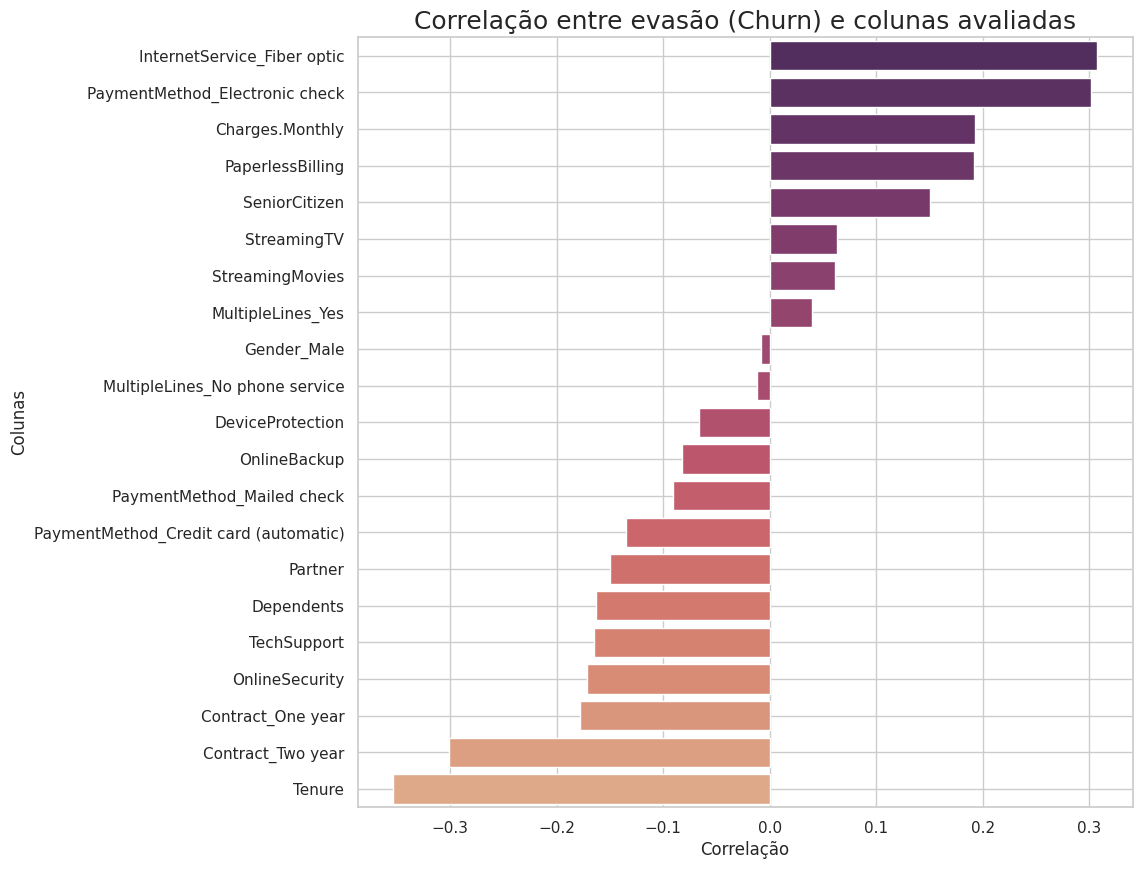

In [135]:
corr_with_churn('Correlação entre evasão (Churn) e colunas avaliadas', data_encoded, True)

#### Eliminando variáveis com pouca correlação com a evasão (Churn)

In [136]:
data_encoded.columns

Index(['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Charges.Monthly',
       'Gender_Male', 'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

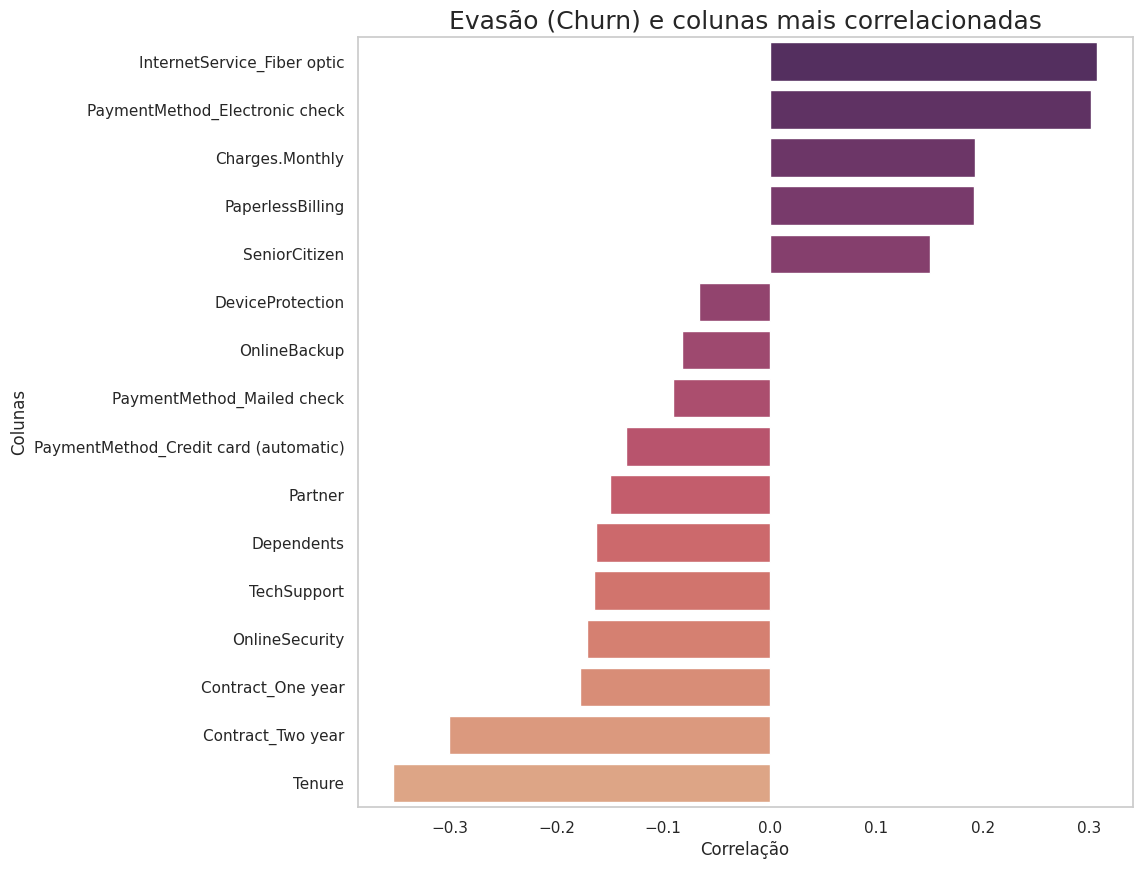

In [162]:
columns_to_remove = ['StreamingTV', 'StreamingMovies', 'Gender_Male', 'MultipleLines_No phone service', 'MultipleLines_Yes']
data_removed_vars = data_encoded.drop(columns=columns_to_remove)

corr_with_churn('Evasão (Churn) e colunas mais correlacionadas', data_removed_vars)

#### VIF com colunas mantidas

In [138]:
X = data_removed_vars.drop(columns='Churn')
X_constant = add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_constant.columns
vif_data['VIF'] = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]

display(vif_data.sort_values(by='VIF', ascending=False))

,Feature,VIF
0,const,18.643417
10,Charges.Monthly,7.427301
11,InternetService_Fiber optic,4.754393
4,Tenure,2.640706
13,Contract_Two year,2.464078
15,PaymentMethod_Electronic check,1.959123
16,PaymentMethod_Mailed check,1.823909
7,DeviceProtection,1.608236
8,TechSupport,1.596043
12,Contract_One year,1.562894


Após a última exclusão de variáveis com pouca correlação com a coluna "Churn", o VIF das colunas "Charges.Monthly" e "InternetService_Fiber optic" diminuiu bastante.  

### Testando novamente os modelos

##### Separação dos dados, normalização e balanceamento

In [139]:
X = data_removed_vars.drop(columns='Churn')
y = data_removed_vars['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_normalized, y_train)

##### Modelo LogisticRegression

In [140]:
model_lr = LogisticRegression()
model_lr.fit(X_train_balanced, y_train_balanced)

y_predict_lr = model_lr.predict(X_test_normalized)
y_probably_lr = model_lr.predict_proba(X_test_normalized)[:, 1]

display_metrics('Modelo Logistic Regression 2', y_test, y_predict_lr, y_probably_lr)

Modelo Logistic Regression 2 

Acurácia: 0.7511848341232228
ROC AUC: 0.8358816970065215
Matriz de Confusão: 
[[1148  401]
 [ 124  437]] 

-------------------------------------------------------
| Relatório de Classificação                          | 
------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1549
           1       0.52      0.78      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110

-------------------------------------------------------


##### Modelo RandomForestClassifier

In [141]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_balanced, y_train_balanced)

y_predict_rf = model_rf.predict(X_test_normalized)
y_probably_rf = model_rf.predict_proba(X_test_normalized)[:, 1]

display_metrics('Modelo Random Forest 2', y_test, y_predict_rf, y_probably_rf)

Modelo Random Forest 2 

Acurácia: 0.7364928909952607
ROC AUC: 0.8061776386122265
Matriz de Confusão: 
[[1129  420]
 [ 136  425]] 

-------------------------------------------------------
| Relatório de Classificação                          | 
------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1549
           1       0.50      0.76      0.60       561

    accuracy                           0.74      2110
   macro avg       0.70      0.74      0.70      2110
weighted avg       0.79      0.74      0.75      2110

-------------------------------------------------------


### Validação cruzada

##### Funções para validação cruzada e intervalo de confiança

In [68]:
def cross_val_model(model, X_train, y_train):
  scoring = ['roc_auc', 'recall', 'f1']

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)

  print('ROC AUC em cada fold:', results['test_roc_auc'])
  print('ROC AUC médio:', results['test_roc_auc'].mean())

  print('\nRecall em cada fold:', results['test_recall'])
  print('Recall médio:', results['test_recall'].mean())

  print('\nF1 score em cada fold:', results['test_f1'])
  print('RF1 score médio:', results['test_f1'].mean())

  return results


def intervalo_confianca(cv_results):
  scores = cv_results['test_recall']
  mean = scores.mean()
  std = scores.std()
  print(f'\nInervalo de confiança: [{mean - 2 * std}, {min(mean + 2 * std, 1)}]')

##### Validação cruzada do modelo LogisticRegression

In [69]:
model_lr_cv = LogisticRegression()
results = cross_val_model(model_lr_cv, X_train_balanced, y_train_balanced)
intervalo_confianca(results)

ROC AUC em cada fold: [0.8345902  0.86383193 0.85484926 0.85464152 0.8465918 ]
ROC AUC médio: 0.8509009416694886

Recall em cada fold: [0.7966805  0.79529737 0.82295989 0.80912863 0.81301939]
Recall médio: 0.8074171561246424

F1 score em cada fold: [0.76443265 0.78284547 0.79333333 0.77948035 0.77491749]
RF1 score médio: 0.7790018584547008

Inervalo de confiança: [0.7866699977205212, 0.8281643145287636]


##### Validação cruzada do modelo LogisticRegression

In [70]:
model_rf_cv = RandomForestClassifier()
results = cross_val_model(model_rf_cv, X_train_balanced, y_train_balanced)
intervalo_confianca(results)

ROC AUC em cada fold: [0.90575805 0.92053052 0.91457046 0.92393478 0.92032754]
ROC AUC médio: 0.9170242713383224

Recall em cada fold: [0.84647303 0.85338866 0.87136929 0.87136929 0.87950139]
Recall médio: 0.8644203323333448

F1 score em cada fold: [0.83893077 0.85457064 0.84848485 0.86006826 0.85637222]
RF1 score médio: 0.8516853475937548

Inervalo de confiança: [0.8396361788493731, 0.8892044858173165]


## Salvando os modelos

In [71]:
import pickle

def save_model(file_name, model_name):
  with open(file_name, 'wb') as file_obj:
    pickle.dump(model_name, file_obj)

save_model('churn_predicter_lr.pkl', model_lr)
save_model('churn_predicter_rf.pkl', model_rf)

In [75]:
X.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'PaperlessBilling',
       'Charges.Monthly', 'InternetService_Fiber optic', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

## Testando os modelos com o dataframe original

#### Função para codificar o dataframe e filtrar apenas as colunas usadas pelos modelos

In [157]:
def encoding_and_remove_columns(df):
  categorical_columns = [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col])]
  df[categorical_columns] = df[categorical_columns].replace('No internet service', 'No')

  categorical_binaries = [col for col in categorical_columns if df[col].nunique() == 2 and col != 'Gender']

  for col in categorical_binaries:
    df[col] = df[col].map({'No': 0, 'Yes': 1, False: 0, True: 1})

  other_categorical = [col for col in categorical_columns if df[col].nunique() > 2 or col == 'Gender']
  df_encoded = pd.get_dummies(df, columns=other_categorical, drop_first=True, dtype=int)

  retained_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'PaperlessBilling',
       'Charges.Monthly', 'InternetService_Fiber optic', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

  df_filtered = df_encoded[retained_columns]

  df_normalized = scaler.transform(df_filtered)

  return df_normalized

#### Importando os dados e preparando para o teste nos modelos

In [158]:
original_df = pd.read_csv(url)

X_prepared = encoding_and_remove_columns(original_df)
y_df = original_df['Churn']

#### Carregando os arquivos dos modelos

In [159]:
model_predictor_lr = pd.read_pickle('/content/churn_predicter_lr.pkl')
model_predictor_rf = pd.read_pickle('/content/churn_predicter_rf.pkl')

#### Testando os modelos com os dados

In [160]:
y_predict_lr = model_predictor_lr.predict(X_prepared)
y_probably_lr = model_predictor_lr.predict_proba(X_prepared)[:, 1]

display_metrics('Usando Modelo de Regressão Linear', y_df, y_predict_lr, y_probably_lr)

Usando Modelo de Regressão Linear 

Acurácia: 0.7535551763367463
ROC AUC: 0.8403258170998379
Matriz de Confusão: 
[[3831 1332]
 [ 401 1468]] 

-------------------------------------------------------
| Relatório de Classificação                          | 
------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      5163
           1       0.52      0.79      0.63      1869

    accuracy                           0.75      7032
   macro avg       0.71      0.76      0.72      7032
weighted avg       0.80      0.75      0.77      7032

-------------------------------------------------------


In [161]:
y_predict_rf = model_predictor_rf.predict(X_prepared)
y_probably_rf = model_predictor_rf.predict_proba(X_prepared)[:, 1]

display_metrics('Usando Modelo Random Forest', y_df, y_predict_rf, y_probably_rf)

Usando Modelo Random Forest 

Acurácia: 0.8455631399317406
ROC AUC: 0.928424221113995
Matriz de Confusão: 
[[4272  891]
 [ 195 1674]] 

-------------------------------------------------------
| Relatório de Classificação                          | 
------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      5163
           1       0.65      0.90      0.76      1869

    accuracy                           0.85      7032
   macro avg       0.80      0.86      0.82      7032
weighted avg       0.88      0.85      0.85      7032

-------------------------------------------------------


# Relatório

### 1. Introdução

Foram avaliadas as correlações entre a evasão de clientes e diferentes variáveis do conjunto de dados. Dois modelos preditivos foram aplicados: Logistic Regression e Random Forest. O primeiro apresentou melhor desempenho utilizando todas as variáveis (primeiro gráfico), enquanto o segundo teve resultados superiores ao considerar apenas as variáveis mais correlacionadas (segundo gráfico).

Essa diferença indica que o Random Forest tende a se beneficiar de variáveis mais relevantes (reduzindo ruído), enquanto a Logistic Regression conseguiu aproveitar informações adicionais mesmo de atributos com menor correlação direta.

### 2. Principais fatores associados à evasão

A análise das correlações aponta alguns fatores críticos que afetam a probabilidade de churn:

* **Serviço de Internet via Fibra Óptica (positivo):** Clientes com fibra ótica apresentam maior tendência de evasão, possivelmente pela associação a planos mais caros ou insatisfação com o custo-benefício.

* **Método de Pagamento – Cheque Eletrônico (positivo):** Usuários que pagam via Electronic check estão mais propensos a abandonar o serviço, sugerindo perfil de clientes menos fidelizados ou com maior rotatividade.

* **Cobrança Mensal (Charges.Monthly) (positivo):** Valores mensais mais altos aumentam a evasão, reforçando a sensibilidade dos clientes ao preço.

* **Faturamento sem papel (PaperlessBilling) (positivo):** Apresenta leve associação com maior evasão, talvez por estar relacionado a clientes mais novos ou com menor vínculo.

* **Idosos (SeniorCitizen) (positivo):** Apontam maior taxa de churn em relação a outras faixas etárias.

* **Tempo de permanência (Tenure) (negativo):** Um dos fatores mais relevantes: clientes antigos têm muito menor propensão à evasão.

* **Tipo de contrato (Contract One year / Two year) (negativo):** Contratos de longo prazo reduzem significativamente a evasão, funcionando como fator de retenção natural.

* **Suporte Técnico e Segurança Online (negativo):** A presença de TechSupport e OnlineSecurity está associada a menor probabilidade de churn, indicando que serviços adicionais aumentam a satisfação e reduzem cancelamentos.

### 3. Estratégias de retenção recomendadas

Com base nos fatores identificados e no desempenho dos modelos, recomenda-se:

**1. Políticas de fidelização:**

* Incentivar contratos anuais/bianuais com descontos ou benefícios.

* Oferecer recompensas progressivas para clientes de maior tempo de permanência.

**2. Ajustes nos planos de fibra ótica:**

* Revisar custos e oferecer opções mais flexíveis para evitar cancelamentos por preço.

* Destacar diferenciais de qualidade frente a concorrentes.

**3. Revisão dos métodos de pagamento:**

* Clientes que utilizam cheque eletrônico devem ser alvo de ações proativas de retenção (e.g., migração para débito automático ou cartão com benefícios).

**4. Aprimoramento da experiência do cliente:**

* Expandir serviços de suporte técnico e segurança online como diferenciais competitivos.

* Monitorar especialmente clientes idosos e oferecer atendimento personalizado.

### 4. Conclusão

Os resultados mostram que a evasão está fortemente associada a preço, forma de pagamento, tempo de permanência e tipo de contrato, além de fatores ligados ao suporte e serviços adicionais. Enquanto a Logistic Regression captou o valor de um conjunto mais amplo de variáveis, o Random Forest destacou melhor as variáveis mais críticas.

Assim, a combinação das duas abordagens fornece um panorama robusto para entender o churn e direcionar estratégias de retenção segmentada.